In [ ]:
# Instead of original training dataframe, we need to make a table of
# with climate data as columns and individual months for individual glaciers
# as rows. In training we need to batch the months to match summer, winter and
# annual mass balance, aggregate the results for each month and evaluate it against
# the summer, winter and annual mass balance using a custom loss function. We can shuffle the batches, 
# but we need to keep the respective batches themselves in the correct order. 

In [63]:
import numpy as np
import pandas as pd
import xgboost as xgb
from plotting_functions import plot_prediction


In [8]:
# Create dummy feature dataset
def create_feature_dataset(n_rows):

    np.random.seed(0)

    data = {
        "t2m": np.random.uniform(-5, 5, n_rows),   # Temperature between -5 and 5
        "tp": np.random.uniform(0, 100, n_rows),   # Total precipitation between 0 and 100
        "fal": np.random.uniform(0, 1, n_rows),    # Albedo between 0 and 1
        "ssr": np.random.uniform(0, 100, n_rows)   # Solar radiation between 0 and 100
    }

    # Create the DataFrame
    df = pd.DataFrame(data)

    return df

num_rows = 600
    
# Using the function to create the dataset
df_features = create_feature_dataset(num_rows)

In [7]:
X_values = df_features.values

In [23]:
months = 6
num_rows_y = int(num_rows/months)

y_values = np.random.uniform(-5, 5, num_rows_y)
print(y_values)
print(y_values.shape)

[-3.5405211   1.32765641  2.92555167  2.7333222  -4.07720402  1.85512719
  2.16023921  3.62166267  0.08044339 -0.38906     4.65116325  2.96512256
  0.58730991 -1.69382929  3.45237996 -0.44563611 -4.07314808 -0.45095727
  3.71968396 -0.51717853 -4.85650852  1.11485324  4.95830003  3.17248584
  1.17237947  4.14398887  3.13581682 -0.01360647  0.91220285  2.31292809
  3.46426164 -4.41823598  2.74803857 -0.5249656   1.6079856   2.64633011
  0.39501925 -3.41485149 -0.90473168 -4.23127006  1.89300691  4.53706182
  2.95252812 -1.10213577  0.84291496 -1.95799324  0.410456   -1.99273094
  2.38324757 -2.40658492  4.6402039   1.61948732 -4.31222152 -4.89222236
  4.97046344 -2.79494422 -1.87437252 -2.91585986  4.28101772  1.5201286
  0.04386324  0.57650814 -1.82127153  1.14175002 -0.80399637 -3.00771854
  1.566051   -1.26159431  2.85066379 -0.84605042  0.08271375  2.87466479
 -0.52121907  4.66221135  2.93028667  3.26430405  4.53920467 -1.11149371
  0.80080264  1.93591741  1.73458484  4.52936795 -2.

In [24]:
#np.tile(Y_values,(6,1))
y_values_rep = np.repeat(y_values, 6)

In [14]:
#dtrain = xgb.DMatrix(X_values, label=Y_values)


In [22]:
#y_true = dtrain.get_label()
#y_true_seasonal = y_true.reshape(-1,6)
#print(y_true_seasonal)
#y_true_agg = np.mean(y_true_seasonal, axis=1)
#print(y_true_agg)
#print(y_true_agg.shape)

## Using low-level Booster interface

In [60]:
# When defining a custom loss function this automatically 
# takes in arguments preds (predictions) and dtrain
def seasonal_mse(preds, dtrain):
    """
    Custom Mean Squared Error loss for seasonal data.
    """
    # Get the true values
    y_true = dtrain.get_label()

    # Assuming 6-month seasons, reshape predictions and true values
    preds_seasonal = preds.reshape(-1, 6)
    y_true_seasonal = y_true.reshape(-1, 6)

    # Aggregate (e.g., sum or average) predictions and true values over the season
    preds_agg = np.sum(preds_seasonal, axis=1)
    y_true_agg = np.mean(y_true_seasonal, axis=1)

    # Calculate the gradient (first derivative) and hessian (second derivative) for MSE
    gradient = preds_agg - y_true_agg
    hessian = np.ones_like(gradient)

    # Reshape gradient and hessian to match the original shape
    gradient = np.repeat(gradient, 6)
    hessian = np.repeat(hessian, 6)

    return gradient, hessian

# Example dataset (replace with your actual data)
#X_train, X_test, y_train, y_test = # load or create your dataset here

# Convert data to DMatrix, which is a data format used by XGBoost
dtrain = xgb.DMatrix(X_values, label=y_values_rep)

# Set up parameters (these are example parameters, tune for your specific case)
params = {'max_depth': 6, 'eta': 0.3}

# Train the model
model = xgb.train(params, dtrain, obj=seasonal_mse, num_boost_round=100)
# num_boost_round is in the case of the Booster interface the same as n_estimators in XGBregressor

# Predictions (you will aggregate these later for evaluation)
#dpred = xgb.DMatrix(X_test)
#preds = model.predict(dpred)

In [26]:
model

In [28]:
model.attributes()

{'best_iteration': '99', 'best_ntree_limit': '100'}

In [31]:
model.get_fscore()

{'f0': 212.0, 'f1': 124.0, 'f2': 121.0, 'f3': 186.0}

In [32]:
model.get_score()

{'f0': 212.0, 'f1': 124.0, 'f2': 121.0, 'f3': 186.0}

In [61]:
preds = model.predict(dtrain)
print(preds[:6].sum())
print(y_values[0])

-3.5404155


-3.540521098184869


## Using Scikit-learn XGBRegressor interface

In [55]:

# Define a custom objective function for seasonal aggregation
def custom_seasonal_obj(y_true, y_pred):
    # Reshape the predictions and true values to represent seasons (6 months in this case)
    y_pred_seasonal = y_pred.reshape(-1, 6)
    y_true_seasonal = y_true.reshape(-1, 6)

    # Aggregate predictions and true values over the season
    y_pred_agg = np.sum(y_pred_seasonal, axis=1)
    y_true_agg = np.mean(y_true_seasonal, axis=1)

    # Compute gradients
    #grad = (y_pred_agg - y_true_agg).repeat(6) / 6
    # Compute Hessians
    #hess = np.ones_like(y_true)

    # Calculate the gradient (first derivative) and hessian (second derivative) for MSE
    grad = y_pred_agg - y_true_agg
    hess = np.ones_like(grad)

    # Reshape gradient and hessian to match the original shape
    grad = np.repeat(grad, 6)
    hess = np.repeat(hess, 6)

    return grad, hess

# Initialize XGBRegressor with the custom objective
model_reg = xgb.XGBRegressor(objective=custom_seasonal_obj)

# Train the model
best_model = model_reg.fit(X_values, y_values_rep)

# Make predictions
#predictions = model.predict(X_test)

# Further code for evaluation, etc.
#predictions[:10]  # Display the first few predictions

In [56]:
best_model.feature_importances_

array([0.19910096, 0.25051194, 0.29249424, 0.25789285], dtype=float32)

In [57]:
predictions = best_model.predict(X_values)

In [58]:
predictions[:10]

array([-0.9803081 ,  0.07559904, -0.41468713, -1.4404745 , -0.20725927,
       -0.57328564, -0.03200315,  0.6866808 ,  0.21791591,  0.12155277],
      dtype=float32)

In [59]:
print(predictions[:6].sum())
print(y_values[0])


-3.5404155
-3.540521098184869


## Test using summer mass balance

### Import and process data

In [2]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_annual = data[data['balance_netto'].notna()]
glacier_data_annual.reset_index(drop=True, inplace=True)

glacier_data_winter = data[data['balance_winter'].notna()]
glacier_data_winter.reset_index(drop=True, inplace=True)

glacier_data_summer = data[data['balance_summer'].notna()]
glacier_data_summer.reset_index(drop=True, inplace=True)

C:\Users\kasj\AppData\Local\Temp\ipykernel_21368\3172944082.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [3]:
glacier_data_summer

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,year
0,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1012,...,0.005116,0.002688,0.002334,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,2013
1,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.001831,0.004597,0.005634,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,2014
2,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.004949,0.003286,0.003739,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,2015
3,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.002495,0.002263,0.001256,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,2016
4,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1016,...,0.003314,0.004417,0.002704,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3924,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.011964,0.007288,0.003555,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759,2012
3925,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.002572,0.000807,0.009360,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759,2013
3926,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.008543,0.010311,0.006261,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759,2015
3927,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.008916,0.003751,0.004573,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759,2016


In [4]:
# Manually select test glaciers (14 glaciers)
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]

# Get test dataset for each of annual, winter and summer mass balance
df_test_annual = glacier_data_annual[glacier_data_annual['BREID'].isin(test_glaciers)]
df_test_winter = glacier_data_winter[glacier_data_winter['BREID'].isin(test_glaciers)]
df_test_summer = glacier_data_summer[glacier_data_summer['BREID'].isin(test_glaciers)]
# 54 has 189 points
# 703 has 30 points
# 941 has 70 points
# 1280 has 71 points
# 2320 has 83 points
# 2478 has 89 points
# 2769 has 121 points
# 3133 has 38 points
# 3137 has 65 points
# 3138 has 6 points
# 3141 has 72 points

# Get training dataset for each of annual, winter and summer mass balance
df_train_annual = glacier_data_annual[~glacier_data_annual['BREID'].isin(test_glaciers)]
df_train_winter = glacier_data_winter[~glacier_data_winter['BREID'].isin(test_glaciers)]
df_train_summer = glacier_data_summer[~glacier_data_summer['BREID'].isin(test_glaciers)]

# Add number of months to each dataframe
df_train_annual['n_months']=12
df_train_winter['n_months']=8
df_train_summer['n_months']=6
df_test_annual['n_months']=12
df_test_winter['n_months']=8
df_test_summer['n_months']=6

print(f'Train/test annual: {len(df_train_annual)}/{len(df_test_annual)}')
print(f'Train/test winter: {len(df_train_winter)}/{len(df_test_winter)}')
print(f'Train/test summer: {len(df_train_summer)}/{len(df_test_summer)}')
print(f'All train/test: {len(df_train_annual)+len(df_train_winter)+len(df_train_summer)} / {len(df_test_annual)+len(df_test_winter)+len(df_test_summer)}')
print(f'Fraction train/test: {(len(df_train_annual)+len(df_train_winter)+len(df_train_summer)) / (len(df_test_annual)+len(df_test_winter)+len(df_test_summer)+len(df_train_annual)+len(df_train_winter)+len(df_train_summer))} / {(len(df_test_annual)+len(df_test_winter)+len(df_test_summer)) /(len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer))}')
print(f'Total entries: {len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer)}')


Train/test annual: 2845/1065
Train/test winter: 2752/1000
Train/test summer: 2901/1028
All train/test: 8498 / 3093
Fraction train/test: 0.7331550340781641 / 0.26684496592183593
Total entries: 11591


C:\Users\kasj\AppData\Local\Temp\ipykernel_21368\1108104880.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_annual['n_months']=12
C:\Users\kasj\AppData\Local\Temp\ipykernel_21368\1108104880.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_winter['n_months']=8
C:\Users\kasj\AppData\Local\Temp\ipykernel_21368\1108104880.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [5]:
df_train_summer

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,year,n_months
172,RGI60-08.02436,G017852E68340N,596,33,617800.0,7584000.0,990.0,NaN,BL36,BL36,...,0.002447,0.003016,0.001702,0.001953,0.004025,0.002591,0.006047,1001.181943,1963,6
173,RGI60-08.02436,G017852E68340N,596,33,617800.0,7584000.0,990.0,NaN,BL36,BL36,...,0.002428,0.001993,0.002906,0.003402,0.003066,0.004062,0.004951,1001.181943,1964,6
174,RGI60-08.02436,G017852E68340N,596,33,617800.0,7584000.0,990.0,NaN,BL36,BL36,...,0.003090,0.001900,0.003094,0.001567,0.003896,0.004033,0.004845,1001.181943,1966,6
175,RGI60-08.02436,G017852E68340N,596,33,617800.0,7584000.0,990.0,NaN,BL36,BL36,...,0.003645,0.003376,0.000861,0.004021,0.006549,0.003302,0.003687,1001.181943,1967,6
176,RGI60-08.02436,G017852E68340N,596,33,617800.0,7584000.0,990.0,NaN,BL36,BL36,...,0.004874,0.004694,0.001514,0.004824,0.003683,0.004470,0.001097,1001.181943,1968,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728,RGI60-08.02643,G006427E60067N,3129,32,357500.0,6662200.0,1530.0,NaN,RUK57,RUK5767,...,0.012723,0.002380,0.003067,0.004948,0.001373,0.001677,0.008620,994.833212,1968,6
3729,RGI60-08.02643,G006427E60067N,3129,32,357300.0,6662500.0,1570.0,NaN,RUK58,RUK58,...,0.000360,0.005509,0.005468,0.009837,0.010945,0.007251,0.008933,994.833212,1964,6
3730,RGI60-08.02643,G006427E60067N,3129,32,357300.0,6662500.0,1570.0,NaN,RUK58,RUK58,...,0.003609,0.002511,0.001531,0.006192,0.002394,0.006272,0.007284,994.833212,1965,6
3731,RGI60-08.02643,G006427E60067N,3129,32,357300.0,6662500.0,1570.0,NaN,RUK58,RUK58,...,0.008622,0.002017,0.004337,0.003802,0.004859,0.004397,0.011932,994.833212,1966,6


In [24]:
# Select columns to drop
cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year', 'lat','lon', 'slope_factor']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
sol_rad_net = ['ssr_oct','ssr_nov','ssr_dec','ssr_jan','ssr_feb','ssr_mar','ssr_apr','ssr_may','ssr_jun','ssr_jul','ssr_aug','ssr_sep']
sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']
#sol_rad_down = ['ssrd_oct','ssrd_nov','ssrd_dec','ssrd_jan','ssrd_feb','ssrd_mar','ssrd_apr','ssrd_may','ssrd_jun','ssrd_jul','ssrd_aug','ssrd_sep']
u_wind = ['u10_oct','u10_nov','u10_dec','u10_jan','u10_feb','u10_mar','u10_apr','u10_may','u10_jun','u10_jul','u10_aug','u10_sep']
v_wind = ['v10_oct','v10_nov','v10_dec','v10_jan','v10_feb','v10_mar','v10_apr','v10_may','v10_jun','v10_jul','v10_aug','v10_sep']
#f_albedo = ['fal_oct','fal_nov','fal_dec','fal_jan','fal_feb','fal_mar','fal_apr','fal_may','fal_jun','fal_jul','fal_aug','fal_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
                         dewpt_temp, surface_pressure, sol_rad_net, sol_therm_down, u_wind, v_wind] for y in x]

# Select features for training
df_train_annual_clean = df_train_annual.drop(drop_cols, axis=1)
df_train_winter_clean = df_train_winter.drop(drop_cols, axis=1)
df_train_summer_clean = df_train_summer.drop(drop_cols, axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_train_summer_clean = df_train_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# df_train_X_... now contains columns of all chosen features and column with annual, winter or summer balance

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        if mon not in mon_winter:
            df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        if mon not in mon_summer:
            df_train_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])

In [25]:
df_train_summer_clean

,BREID,altitude,balance,aspect,slope,t2m_oct,t2m_nov,t2m_dec,t2m_jan,t2m_feb,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,n_months
172,596,990.0,-3.41,2.509464,0.238202,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001702,0.001953,0.004025,0.002591,0.006047,1001.181943,6
173,596,996.0,-2.16,2.474161,0.117946,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.002906,0.003402,0.003066,0.004062,0.004951,1001.181943,6
174,596,988.0,-2.90,2.509464,0.238202,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003094,0.001567,0.003896,0.004033,0.004845,1001.181943,6
175,596,990.0,-3.16,2.478294,0.146882,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000861,0.004021,0.006549,0.003302,0.003687,1001.181943,6
176,596,990.0,-1.90,2.478294,0.146882,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001514,0.004824,0.003683,0.004470,0.001097,1001.181943,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728,3129,1551.0,-2.35,2.115165,0.111223,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003067,0.004948,0.001373,0.001677,0.008620,994.833212,6
3729,3129,1571.0,-1.29,2.312361,0.097301,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.005468,0.009837,0.010945,0.007251,0.008933,994.833212,6
3730,3129,1587.0,-1.80,2.482095,0.070551,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001531,0.006192,0.002394,0.006272,0.007284,994.833212,6
3731,3129,1590.0,-2.81,2.339748,0.073072,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.004337,0.003802,0.004859,0.004397,0.011932,994.833212,6


In [29]:
df_train_summer_clean = df_train_summer_clean.dropna(axis=1, how='all')

In [30]:
df_train_summer_clean.columns.to_list()

['BREID',
 'altitude',
 'balance',
 'aspect',
 'slope',
 't2m_may',
 't2m_jun',
 't2m_jul',
 't2m_aug',
 't2m_sep',
 'fal_may',
 'fal_jun',
 'fal_jul',
 'fal_aug',
 'fal_sep',
 'slhf_may',
 'slhf_jun',
 'slhf_jul',
 'slhf_aug',
 'slhf_sep',
 'str_may',
 'str_jun',
 'str_jul',
 'str_aug',
 'str_sep',
 'sshf_may',
 'sshf_jun',
 'sshf_jul',
 'sshf_aug',
 'sshf_sep',
 'ssrd_may',
 'ssrd_jun',
 'ssrd_jul',
 'ssrd_aug',
 'ssrd_sep',
 'tp_may',
 'tp_jun',
 'tp_jul',
 'tp_aug',
 'tp_sep',
 'altitude_climate',
 'n_months']

In [37]:
# Columns that are not monthly climate variables (identifiers and static variables)
id_vars = ['BREID', 'altitude','balance','aspect','slope','altitude_climate','n_months']

# Extract the unique variable names and month names from the column names
#variables = set(col.split('_')[0] for col in df.columns if col not in id_vars)
#months = set(col.split('_')[-1] for col in df.columns if col not in id_vars)
variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
months_order = ['may', 'jun', 'jul', 'aug', 'sep']

# Prepare a list to hold the reshaped DataFrames for each variable
df_list = []

for var in variables:
    # Filter columns for the current variable and the ID columns
    cols = [col for col in df_train_summer_clean.columns if col.startswith(var) or col in id_vars]
    df_var = df_train_summer_clean[cols]

    # Rename the columns to have just the month
    df_var = df_var.rename(columns=lambda x: x.split('_')[-1] if x not in id_vars else x)

    # Melt the DataFrame to long format and add month order
    df_melted = pd.melt(df_var, id_vars=id_vars, var_name='month', value_name=var)
    df_melted['month'] = pd.Categorical(df_melted['month'], categories=months_order, ordered=True)

    # Append the reshaped DataFrame to the list
    df_list.append(df_melted)

# Combine all reshaped DataFrames
df_final = df_list[0]
for df_temp in df_list[1:]:
    df_final = pd.merge(df_final, df_temp, on=id_vars + ['month'], how='outer')

# Sort the DataFrame based on ID variables and month
df_final = df_final.sort_values(by=id_vars + ['month'])


In [38]:
df_final

,BREID,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
82,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,may,271.778687,93903.000,-393356.0,21712848.0,0.719680,-3898658.75,0.000861
4999,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,jun,274.179108,-142581.000,-456671.5,18036852.0,0.636215,-1912245.25,0.004021
9916,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,jul,277.781219,-530140.000,-1020132.0,13634819.0,0.460673,-1183857.00,0.006549
14833,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,aug,280.827637,-1322854.625,-2858846.0,9900008.0,0.162629,-3083705.75,0.003302
19750,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,sep,277.611938,-535290.250,-1280799.5,5031936.5,0.212322,-2043465.00,0.003687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4884,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,may,274.327118,-927999.500,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
9801,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,jun,277.050171,-842161.375,101172.0,20268490.0,0.551025,-2504472.50,0.007480
14718,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,jul,278.294403,-492371.250,282694.5,15490057.0,0.481296,-862670.75,0.006605
19635,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,aug,280.939240,-1117701.750,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


In [40]:
df_final.reset_index(drop=True, inplace=True)
df_final

,BREID,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,may,271.778687,93903.000,-393356.0,21712848.0,0.719680,-3898658.75,0.000861
1,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,jun,274.179108,-142581.000,-456671.5,18036852.0,0.636215,-1912245.25,0.004021
2,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,jul,277.781219,-530140.000,-1020132.0,13634819.0,0.460673,-1183857.00,0.006549
3,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,aug,280.827637,-1322854.625,-2858846.0,9900008.0,0.162629,-3083705.75,0.003302
4,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,sep,277.611938,-535290.250,-1280799.5,5031936.5,0.212322,-2043465.00,0.003687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24580,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,may,274.327118,-927999.500,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
24581,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,jun,277.050171,-842161.375,101172.0,20268490.0,0.551025,-2504472.50,0.007480
24582,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,jul,278.294403,-492371.250,282694.5,15490057.0,0.481296,-862670.75,0.006605
24583,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,aug,280.939240,-1117701.750,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


In [41]:
# Select features for training
df_train_X = df_final.drop(['balance','BREID','n_months','month'], axis=1)

# Select labels for training
df_train_y = df_final[['balance']]

# Get arrays of features and targets
X_train, y_train = df_train_X.values, df_train_y.values

In [87]:
# Prepare test

# Select features for training
df_test_annual_clean = df_test_annual.drop(drop_cols, axis=1)
df_test_winter_clean = df_test_winter.drop(drop_cols, axis=1)
df_test_summer_clean = df_test_summer.drop(drop_cols, axis=1)
df_test_annual_clean = df_test_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_test_winter_clean = df_test_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_test_summer_clean = df_test_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_test_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_test_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_test_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        if mon not in mon_winter:
            df_test_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        if mon not in mon_summer:
            df_test_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
df_test_all = pd.concat([df_test_annual_clean, df_test_summer_clean, df_test_winter_clean])
df_test_all.reset_index(drop=True, inplace=True)


In [88]:
df_test_summer_clean

,BREID,altitude,balance,aspect,slope,t2m_oct,t2m_nov,t2m_dec,t2m_jan,t2m_feb,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,n_months
0,54,471.0,-6.24,0.629597,0.278773,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,6
1,54,439.0,-4.35,0.585924,0.296590,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,6
2,54,444.0,-4.17,0.663261,0.302508,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,6
3,54,444.0,-4.37,0.663261,0.302508,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,6
4,54,468.0,-4.05,0.836757,0.309196,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3924,3141,1078.0,-3.57,2.906044,0.131717,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759,6
3925,3141,1078.0,-4.29,2.906044,0.131717,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759,6
3926,3141,1079.0,-3.80,2.906044,0.131717,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759,6
3927,3141,1078.0,-4.38,2.906044,0.131717,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759,6


In [89]:
df_test_summer_clean = df_test_summer_clean.dropna(axis=1, how='all')

In [90]:
df_test_summer_clean

,BREID,altitude,balance,aspect,slope,t2m_may,t2m_jun,t2m_jul,t2m_aug,t2m_sep,...,ssrd_jul,ssrd_aug,ssrd_sep,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,n_months
0,54,471.0,-6.24,0.629597,0.278773,277.677979,283.339630,283.829285,283.778412,280.982513,...,15538729.0,10510849.0,6908671.0,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,6
1,54,439.0,-4.35,0.585924,0.296590,273.853424,278.533508,286.991089,283.409485,278.292114,...,18042530.0,11039758.0,5959149.5,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,6
2,54,444.0,-4.17,0.663261,0.302508,275.326904,277.934570,282.700439,284.425964,280.746399,...,16689025.0,10871432.0,5295579.5,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,6
3,54,444.0,-4.37,0.663261,0.302508,277.405426,279.781555,284.442657,282.017212,281.270203,...,12798462.0,10218002.0,5514606.5,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,6
4,54,468.0,-4.05,0.836757,0.309196,272.579590,278.621582,283.518036,282.460541,280.259796,...,14254989.0,10143777.0,7109445.5,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3924,3141,1078.0,-3.57,2.906044,0.131717,276.051880,279.342010,282.147797,282.897827,277.707581,...,13498130.0,12668262.0,6896097.0,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759,6
3925,3141,1078.0,-4.29,2.906044,0.131717,277.164032,280.542206,284.284760,282.710297,280.058624,...,16972544.0,13084008.0,7385662.5,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759,6
3926,3141,1079.0,-3.80,2.906044,0.131717,274.069031,278.133453,281.378021,283.121002,280.627228,...,14995219.0,13300601.0,8539609.0,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759,6
3927,3141,1078.0,-4.38,2.906044,0.131717,278.187347,283.209045,282.545563,282.466614,282.774078,...,12746544.0,10608194.0,8065051.0,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759,6


In [91]:
# Columns that are not monthly climate variables (identifiers and static variables)
id_vars = ['BREID', 'altitude','balance','aspect','slope','altitude_climate','n_months']

# Extract the unique variable names and month names from the column names
#variables = set(col.split('_')[0] for col in df.columns if col not in id_vars)
#months = set(col.split('_')[-1] for col in df.columns if col not in id_vars)
variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
months_order = ['may', 'jun', 'jul', 'aug', 'sep']

# Prepare a list to hold the reshaped DataFrames for each variable
df_list = []

for var in variables:
    # Filter columns for the current variable and the ID columns
    cols = [col for col in df_test_summer_clean.columns if col.startswith(var) or col in id_vars]
    df_var = df_test_summer_clean[cols]

    # Rename the columns to have just the month
    df_var = df_var.rename(columns=lambda x: x.split('_')[-1] if x not in id_vars else x)

    # Melt the DataFrame to long format and add month order
    df_melted = pd.melt(df_var, id_vars=id_vars, var_name='month', value_name=var)
    df_melted['month'] = pd.Categorical(df_melted['month'], categories=months_order, ordered=True)

    # Append the reshaped DataFrame to the list
    df_list.append(df_melted)

# Combine all reshaped DataFrames
df_test_final = df_list[0]
for df_temp in df_list[1:]:
    df_test_final = pd.merge(df_test_final, df_temp, on=id_vars + ['month'], how='outer')

# Sort the DataFrame based on ID variables and month
df_test_final = df_test_final.sort_values(by=id_vars + ['month'])

In [92]:
df_test_final

,BREID,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
10,54,400.0,-4.18,1.283742,0.162952,341.227919,6,may,274.472870,2.552786e+05,-348422.00,18054698.0,0.663828,-2917164.75,0.003328
1416,54,400.0,-4.18,1.283742,0.162952,341.227919,6,jun,279.946289,-2.202645e+05,-1346158.00,20163438.0,0.423285,-3229566.50,0.002498
2822,54,400.0,-4.18,1.283742,0.162952,341.227919,6,jul,281.683960,-2.243898e+06,-4249753.00,13524089.0,0.131924,-4107109.50,0.004562
4228,54,400.0,-4.18,1.283742,0.162952,341.227919,6,aug,281.627777,-1.479509e+06,-3182574.25,10970805.0,0.130799,-4367902.00,0.002152
5634,54,400.0,-4.18,1.283742,0.162952,341.227919,6,sep,279.607697,-1.618945e+05,-1336711.50,5659001.5,0.132435,-3476266.75,0.002351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,3141,1585.0,-1.42,3.830213,0.013718,1040.093546,6,may,277.900391,1.226588e+05,-109966.00,22470520.0,0.670076,-3584976.00,0.001143
2781,3141,1585.0,-1.42,3.830213,0.013718,1040.093546,6,jun,279.539368,2.505575e+05,33005.50,18861446.0,0.653503,-1534874.25,0.007373
4187,3141,1585.0,-1.42,3.830213,0.013718,1040.093546,6,jul,284.332581,-1.189755e+05,-1342583.50,18833054.0,0.556072,-1499186.75,0.005612
5593,3141,1585.0,-1.42,3.830213,0.013718,1040.093546,6,aug,282.079468,-1.170063e+06,-2647197.50,12839022.0,0.385999,-2697184.00,0.005260


In [93]:
# Select features for training
df_test_X = df_test_final.drop(['balance','BREID','n_months','month'], axis=1)

# Select labels for training
df_test_y = df_test_final[['balance']]

# Get arrays of features and targets
X_test, y_test = df_test_X.values, df_test_y.values

In [94]:
df_test_X

,altitude,aspect,slope,altitude_climate,t2m,sshf,slhf,ssrd,fal,str,tp
10,400.0,1.283742,0.162952,341.227919,274.472870,2.552786e+05,-348422.00,18054698.0,0.663828,-2917164.75,0.003328
1416,400.0,1.283742,0.162952,341.227919,279.946289,-2.202645e+05,-1346158.00,20163438.0,0.423285,-3229566.50,0.002498
2822,400.0,1.283742,0.162952,341.227919,281.683960,-2.243898e+06,-4249753.00,13524089.0,0.131924,-4107109.50,0.004562
4228,400.0,1.283742,0.162952,341.227919,281.627777,-1.479509e+06,-3182574.25,10970805.0,0.130799,-4367902.00,0.002152
5634,400.0,1.283742,0.162952,341.227919,279.607697,-1.618945e+05,-1336711.50,5659001.5,0.132435,-3476266.75,0.002351
...,...,...,...,...,...,...,...,...,...,...,...
1375,1585.0,3.830213,0.013718,1040.093546,277.900391,1.226588e+05,-109966.00,22470520.0,0.670076,-3584976.00,0.001143
2781,1585.0,3.830213,0.013718,1040.093546,279.539368,2.505575e+05,33005.50,18861446.0,0.653503,-1534874.25,0.007373
4187,1585.0,3.830213,0.013718,1040.093546,284.332581,-1.189755e+05,-1342583.50,18833054.0,0.556072,-1499186.75,0.005612
5593,1585.0,3.830213,0.013718,1040.093546,282.079468,-1.170063e+06,-2647197.50,12839022.0,0.385999,-2697184.00,0.005260


### Train model

In [114]:
# When defining a custom loss function this automatically 
# takes in arguments preds (predictions) and dtrain
def seasonal_mse(preds, dtrain):
    """
    Custom Mean Squared Error loss for seasonal data.
    """
    # Get the true values
    y_true = dtrain.get_label()

    # Assuming 6-month seasons, reshape predictions and true values
    preds_seasonal = preds.reshape(-1, 5)
    y_true_seasonal = y_true.reshape(-1, 5)

    # Aggregate (e.g., sum or average) predictions and true values over the season
    preds_agg = np.sum(preds_seasonal, axis=1)
    y_true_agg = np.mean(y_true_seasonal, axis=1)

    # Calculate the gradient (first derivative) and hessian (second derivative) for MSE
    gradient = preds_agg - y_true_agg
    hessian = np.ones_like(gradient)

    # Reshape gradient and hessian to match the original shape
    gradient = np.repeat(gradient, 5)
    hessian = np.repeat(hessian, 5)

    return gradient, hessian

# Example dataset (replace with your actual data)
#X_train, X_test, y_train, y_test = # load or create your dataset here

# Convert data to DMatrix, which is a data format used by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Set up parameters (these are example parameters, tune for your specific case)
params = {'max_depth': 4, 'eta': 0.3}

# Train the model
model = xgb.train(params, dtrain, obj=seasonal_mse, num_boost_round=200)
# num_boost_round is in the case of the Booster interface the same as n_estimators in XGBregressor

# Predictions (you will aggregate these later for evaluation)
#dpred = xgb.DMatrix(X_test)
#preds = model.predict(dpred)

In [115]:
preds = model.predict(dtrain)
print(preds[:5])
print(preds[:5].sum())
print(y_train[0])

[-0.41689366 -0.4550777  -0.47757766 -0.829338   -0.66489935]
-2.8437865
[-2.98]


In [116]:
print(preds[5])


-0.37203494


In [117]:
preds = model.predict(dtrain)
print(preds[5:10])
print(preds[5:10].sum())
print(y_train[5])

[-0.37203494 -0.43014026 -0.41372335 -0.38544875 -0.26398343]
-1.8653307
[-1.79]


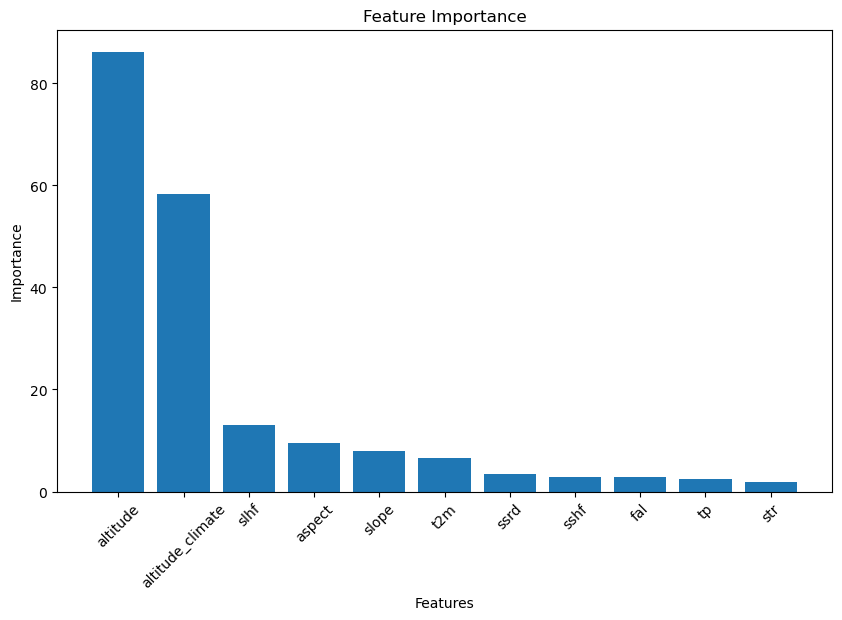

In [118]:
# Feature importance: gain
#Gain:
#Description: Gain measures the average gain of a feature when it is used in trees. The gain is a measure of the improvement in accuracy brought by a feature to the branches it is on.
#Interpretation: A higher gain value when a feature is used implies the feature is more useful for improving the model's performance. Gain is a more nuanced metric compared to weight, as it takes into account the effectiveness of each feature in improving the model.
#Use Case: This is often considered the most important metric, as it gives a clearer indication of the contribution of each feature to the model's predictive power.

# Get the feature names from the DataFrame
feature_names = df_train_X.columns

# Map 'f0', 'f1', etc. to actual feature names
fmap = {f'f{i}': name for i, name in enumerate(feature_names)}

# Get feature importance and map feature names
feature_importance = model.get_score(importance_type='gain')
feature_importance = {fmap[k]: v for k, v in feature_importance.items()}

# Sorting the features based on importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.xticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

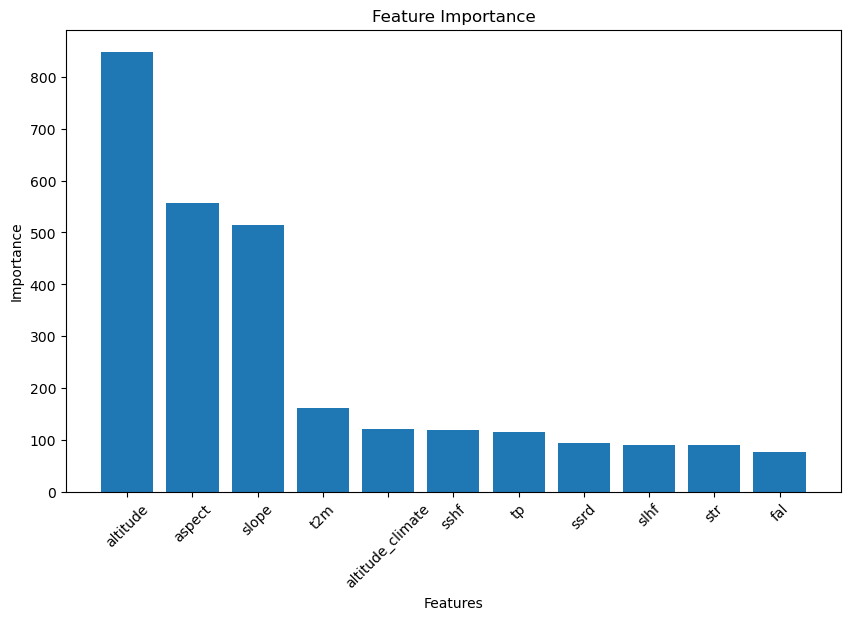

In [119]:
# Feature importance: weight
#Weight (Frequency):
#Description: This metric counts the number of times a feature is used to split the data across all trees.
#Interpretation: A feature with a higher weight has been used more often in decision nodes of trees. This indicates it's generally more important for making splits, but doesn't necessarily imply a strong predictive power.
#Use Case: Useful for understanding which features are frequently considered in the model's decision-making process.

# Get the feature names from the DataFrame
feature_names = df_train_X.columns

# Map 'f0', 'f1', etc. to actual feature names
fmap = {f'f{i}': name for i, name in enumerate(feature_names)}

# Get feature importance and map feature names
feature_importance = model.get_score(importance_type='weight')
feature_importance = {fmap[k]: v for k, v in feature_importance.items()}

# Sorting the features based on importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.xticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

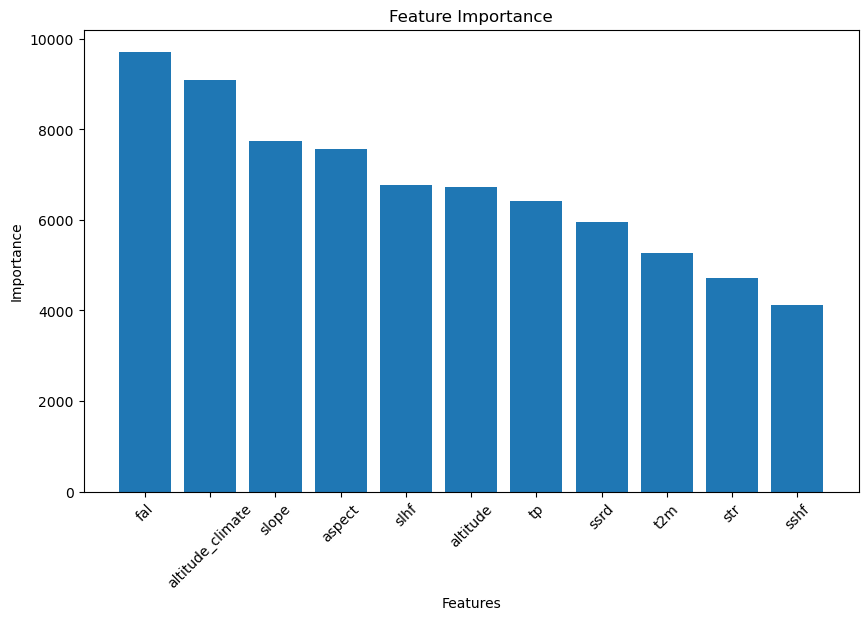

In [105]:
# Feature importance cover: 
#Cover:
#Description: Cover measures the average coverage of a feature when it is used in trees. Coverage is defined as the number of samples affected by the split.
#Interpretation: A higher cover value indicates that the feature is used in splits that affect more samples. It gives an idea of the range of influence of the feature in the dataset.
#Use Case: Useful for understanding the impact of a feature on the data distribution in the model.

# Get the feature names from the DataFrame
feature_names = df_train_X.columns

# Map 'f0', 'f1', etc. to actual feature names
fmap = {f'f{i}': name for i, name in enumerate(feature_names)}

# Get feature importance and map feature names
feature_importance = model.get_score(importance_type='cover')
feature_importance = {fmap[k]: v for k, v in feature_importance.items()}

# Sorting the features based on importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.xticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [120]:
#test_model = cv_grid.best_estimator_
#test_model.fit(X_train, y_train)
y_pred = model.predict(dtrain)
#plot_prediction(y_test, y_pred_test, data_type='Test')

In [68]:
y_pred.shape

(24585,)

In [121]:
y_pred_sum = y_pred.reshape(-1, 5).sum(axis=1)

In [83]:
y_pred_sum.shape

(4917,)

In [122]:
y_train_mean = y_train.reshape(-1,5).mean(axis=1)

In [79]:
y_train_mean

array([-2.98, -1.79, -3.07, ..., -2.81, -2.17, -1.09])

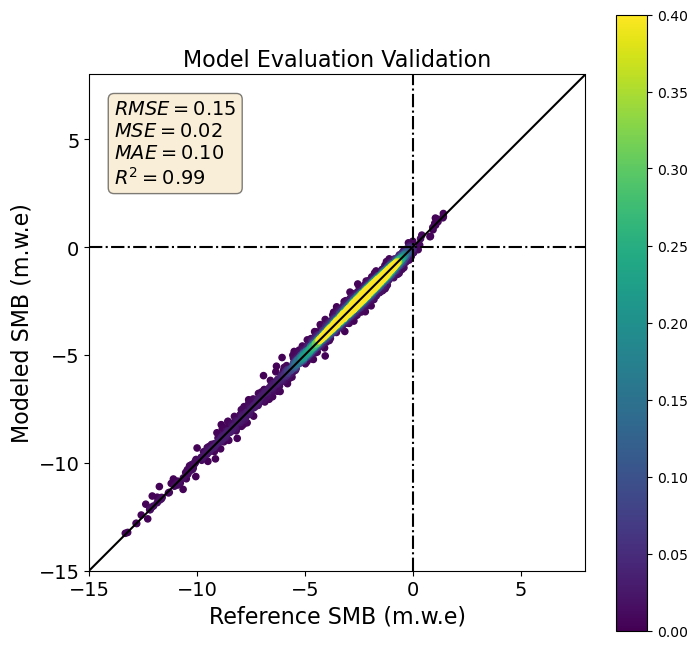

In [123]:
plot_prediction(y_train_mean, y_pred_sum, data_type='Validation')

### Test model

In [124]:
dtest = xgb.DMatrix(X_test)
preds_test = model.predict(dtest)

In [125]:
y_test_pred_sum = preds_test.reshape(-1, 5).sum(axis=1)

In [126]:
y_test_mean = y_test.reshape(-1,5).mean(axis=1)

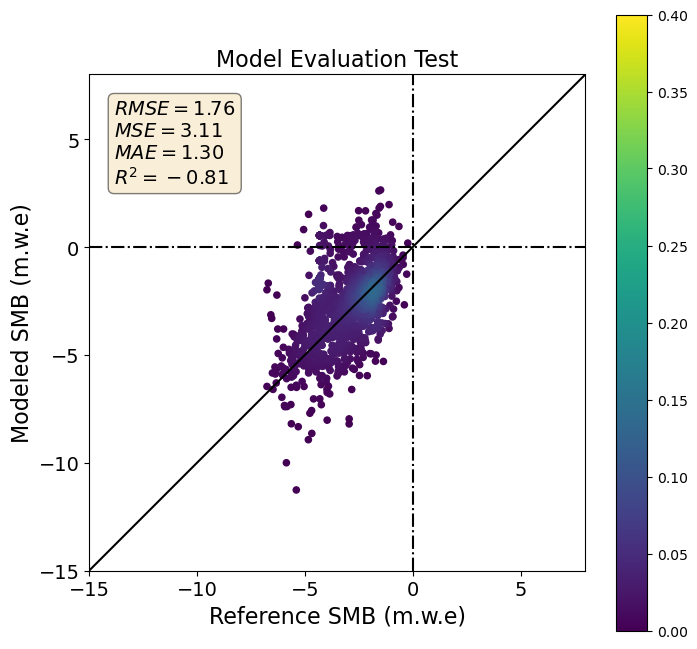

In [127]:
plot_prediction(y_test_mean, y_test_pred_sum, data_type='Test')

## Model training with hyperparameter search

In [ ]:
# Define evaluation functions
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
def your_evaluation_function(y_test, predictions):


In [ ]:

import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold
from itertools import product

# Assume seasonal_mse is your custom loss function
def seasonal_mse(y_true, y_pred):
    # Implementation of your custom loss function
    pass

# Example: prepare your data here
# X, y = ...

# Define your hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'eta': [0.01, 0.1, 0.3],
    # Add other hyperparameters here
}

# K-fold cross-validation setup
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store the average performance for each parameter set
performance_grid = {}

# Grid search
for param_combination in product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), param_combination))
    fold_results = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        bst = xgb.train(params, dtrain, num_boost_round=100, obj=seasonal_mse)
        
        # Assuming you have a function to calculate your evaluation metric
        predictions = bst.predict(dtest)
        fold_results.append(mean_squared_error(y_test, predictions))

    # Calculate average performance across all folds for the current parameter set
    average_performance = np.mean(fold_results)
    performance_grid[param_combination] = average_performance

# Find the best parameters
best_params = max(performance_grid, key=performance_grid.get)
best_performance = performance_grid[best_params]

print("Best Parameters:", best_params)
print("Best Performance:", best_performance)